In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
series    = '20220406_125443'
data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)

In [3]:
## Grab the file with no calibration offset
file_list = np.sort(glob.glob(data_path+"/*.h5"))

summary_file = "None"
delay_file   = "None"
VNA_file     = "None"
tone_files   = []

for file in file_list:
    
    if "Delay" in file:
        delay_file = file
        
    if "VNA" in file:
        VNA_file = file
        
    if "noise_averages" in file:
        summary_file = file
        
    if "delta" in file:
        tone_files = np.append(tone_files, file)

print("Line Delay file: ",delay_file)
print("VNA scan file:   ",VNA_file)
print("Timestream files:",tone_files)
print("Summary file:    ",summary_file)

Line Delay file:  /data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Delay_20220406_125443.h5
VNA scan file:    /data/USRP_Noise_Scans/20220406/20220406_125443/USRP_VNA_20220406_125443.h5
Timestream files: ['/data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta-5.h5'
 '/data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta0.h5'
 '/data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta0_cleaned.h5'
 '/data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta5.h5']
Summary file:     /data/USRP_Noise_Scans/20220406/20220406_125443/noise_averages_20220406_125443.h5


In [4]:
## First pull metadata from the noise averages summary file
fsum = h5py.File(summary_file, 'r')
md   = fsum['Power0']
print(md.keys())
print(md.attrs.keys())

LOfreq   = md.attrs["LOfreq"]
N_power  = md.attrs["N_power"]
delay_ns = md.attrs["delay_ns"]
power    = md.attrs["power"]
rate     = md.attrs["rate"]
rx_gain  = md.attrs["rx_gain"]
tx_gain  = md.attrs["tx_gain"]

frequencies = np.array(md['freqs'])
noise_means = np.array(md['means'])

S0 = md['Scan0'] ; print(S0.keys())
S1 = md['Scan1'] ; print(S1.keys())
S2 = md['Scan2'] ; print(S2.keys())
print(md['VNA'])
print(frequencies)
print(noise_means)

print("Scan0 tones:", np.array(S0['readout_tones']))
print("Scan1 tones:", np.array(S1['readout_tones']))
print("Scan2 tones:", np.array(S2['readout_tones']))

<KeysViewHDF5 ['Scan0', 'Scan1', 'Scan2', 'VNA', 'freqs', 'means']>
<KeysViewHDF5 ['LOfreq', 'N_power', 'delay_ns', 'power', 'rate', 'rx_gain', 'tx_gain']>
<KeysViewHDF5 ['LOfrequency', 'amplitudes', 'readout_tones', 'relative_tones']>
<KeysViewHDF5 ['LOfrequency', 'amplitudes', 'readout_tones', 'relative_tones']>
<KeysViewHDF5 ['LOfrequency', 'amplitudes', 'readout_tones', 'relative_tones']>
<HDF5 group "/Power0/VNA" (2 members)>
[4242.181262 4242.182059 4242.182856]
[0.00714393+0.0038569j  0.00699066+0.00424968j 0.00694883+0.00463577j]
Scan0 tones: [4.24218126e+09 4.23500000e+09 4.25500000e+09]
Scan1 tones: [4.24218206e+09 4.23500000e+09 4.25500000e+09]
Scan2 tones: [4.24218286e+09 4.23500000e+09 4.25500000e+09]


In [5]:
## Check out the contents of the line delay file
f  = h5py.File(delay_file, 'r')
print("Top  level:", f.keys(), f.attrs.keys())
print("Delay Info:", f["delay_info"].keys(), f["delay_info"].attrs.keys())
print("Raw  Data0:", f["raw_data0" ].keys(), f["raw_data0" ].attrs.keys())

print("A_RX2:",f["raw_data0"]['A_RX2'].keys())
f.close()

Top  level: <KeysViewHDF5 ['delay_info', 'raw_data0']> <KeysViewHDF5 []>
Delay Info: <KeysViewHDF5 []> <KeysViewHDF5 ['100']>
Raw  Data0: <KeysViewHDF5 ['A_RX2', 'A_TXRX']> <KeysViewHDF5 ['meas_type']>
A_RX2: <KeysViewHDF5 ['data', 'errors', 'ext']>


In [6]:
## Check out the contents of the VNA file
f  = h5py.File(VNA_file, 'r')
print("Top-level:", f.keys(), f.attrs.keys())
print("Raw Data0:", f["raw_data0" ].keys(), f["raw_data0" ].attrs.keys())
print("A_RX2:",f["raw_data0"]['A_RX2'].keys())

VNA_data = f["raw_data0"]['A_RX2']['data']
VNA_errs = f["raw_data0"]['A_RX2']['errors']
VNA_ext  = f["raw_data0"]['A_RX2']['ext']

f.close()
del f

Top-level: <KeysViewHDF5 ['raw_data0']> <KeysViewHDF5 []>
Raw Data0: <KeysViewHDF5 ['A_RX2', 'A_TXRX']> <KeysViewHDF5 ['meas_type']>
A_RX2: <KeysViewHDF5 ['data', 'errors', 'ext']>


In [7]:
f = h5py.File(tone_files[1], 'r')
print("Tones in file:", np.array(S1['readout_tones']))
print("Top-level:", f.keys())
print("Raw Data0:", f["raw_data0"].keys())
print("A_RX2:", f["raw_data0"]["A_RX2"].keys())

tone_data = f["raw_data0"]["A_RX2"]['data']
tone_errs = f["raw_data0"]["A_RX2"]['errors']
tone_ext  = f["raw_data0"]["A_RX2"]['ext']

print(np.shape(np.array(tone_data)))
f.close()



Tones in file: [4.24218206e+09 4.23500000e+09 4.25500000e+09]
Top-level: <KeysViewHDF5 ['pulses', 'raw_data0']>
Raw Data0: <KeysViewHDF5 ['A_RX2', 'A_TXRX']>
A_RX2: <KeysViewHDF5 ['data', 'errors', 'ext']>
(3, 30000000)


In [8]:
def logMag(z):
    r = np.real(z)
    i = np.imag(z)
    return np.log10( np.sqrt( np.power(r,2.) + np.power(i,2.) ) )

def phase(z):
    r = np.real(z)
    i = np.imag(z)
    return np.pi + np.arctan2( i , r )

def timesFromRate(rate, length):
    ## rate passed in "samples per second"
    ## length is the number of points in array
    f = 1./rate
    times = np.arange(start=0, stop=f*(length), step=f)
    return times

In [9]:
# sys.path.append()
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf

# Calibration Delta = 0

Power:  -40
Will separate data into  3000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta0.h5 because override=True!
found 31 pulses
chunk length plugged into welch is 500
chunked data into 3000 timestreams
computed electronics basis
cleaning...
(2, 1038000)
(1, 1038000)
(1, 1038000)
(2, 1038000)
(1, 1038000)
(1, 1038000)
0.010676050459956617
0.40287159126776817
saving clean_data to /data/USRP_Noise_Scans/20220406/20220406_125443/USRP_Noise_20220406_125443_delta0_cleaned.h5 because override=True!
number of chunks used to average is 2076


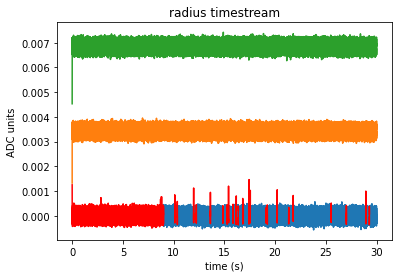

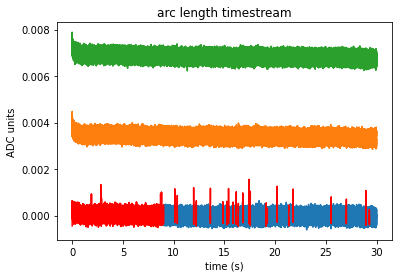

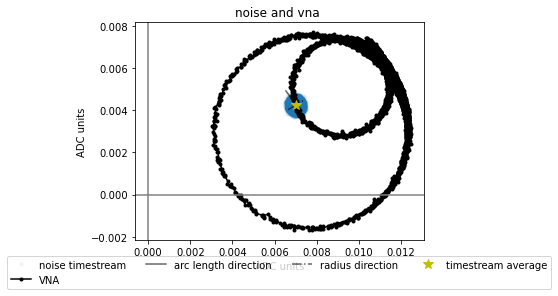

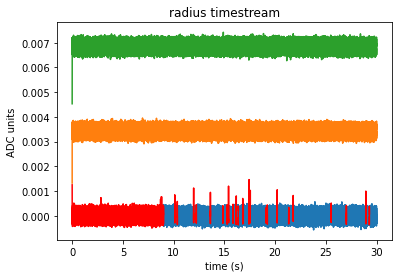

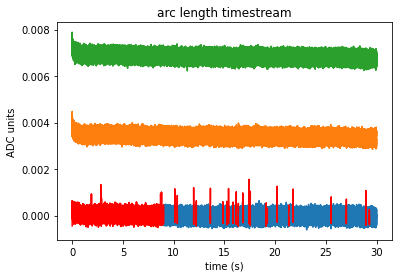

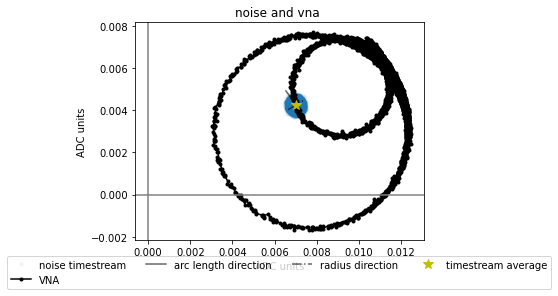

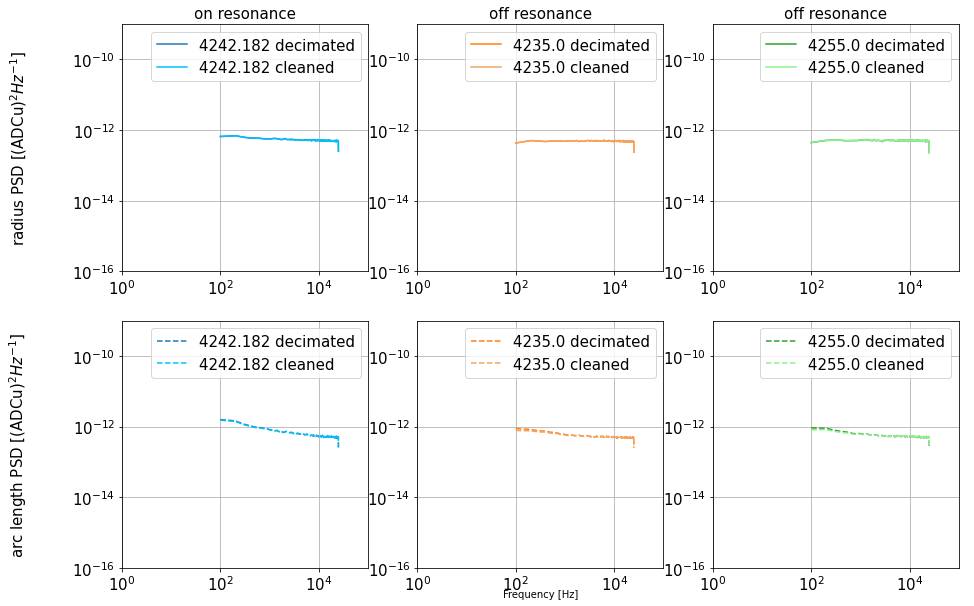

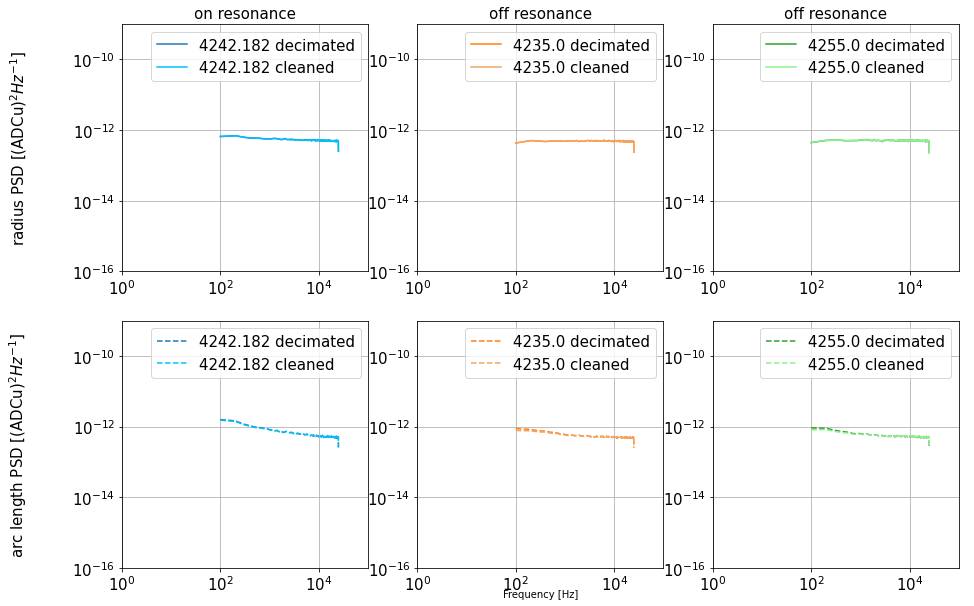

In [10]:
PSD_lo_f = int(1e2)  ## chunk up to [Hz]
PSD_hi_f = int(5e4)  ## decimate down to  [Hz]

print("Power: ",power)

_, noise_info = PUf.unavg_noi(tone_files[1])
noise_total_time = noise_info['time'][-1]
noise_fs = 1./noise_info['sampling period']
noise_readout_f = noise_info['search freqs'][0]

num_chunks = int(noise_total_time*PSD_lo_f)
noise_decimation = int(noise_fs/PSD_hi_f)

print("Will separate data into ", num_chunks      , "chunks to achieve the requested", "{:.2e}".format(PSD_lo_f),' Hz low  end of the PSD')
print("Additional decimation by", noise_decimation, "needed to achieve the requested", "{:.2e}".format(PSD_hi_f),' Hz high end of the PSD')

powers, PSDs, res, timestreams = Prf.PSDs_and_cleaning(tone_files[1], VNA_file,
                                                      extra_dec  = noise_decimation,
                                                      num_chunks = num_chunks,
                                                      blank_chunks = int(0.3*num_chunks),
                                                      removal_decimation = 1)

## Look at cleaned data file

In [11]:
f_in = tone_files[1].split('.')[0]+"_cleaned.h5"
f    = h5py.File(f_in, 'r')
print("Top-level:", f.keys(), f.attrs.keys())


Top-level: <KeysViewHDF5 ['angle', 'arc cleaning coefficient', 'cleaned_data', 'radius', 'radius cleaning coefficient', 'sampling_rate']> <KeysViewHDF5 []>


## Look for pulses

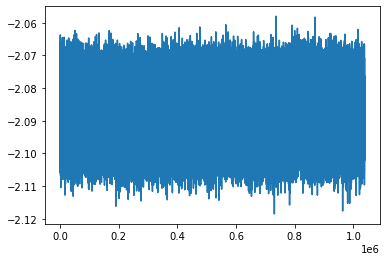

In [33]:
f = h5py.File(tone_files[1], 'r')
f_clean = h5py.File(tone_files[1].split('.')[0]+"_cleaned.h5", 'r')
# print("Top-level:", f.keys())
# print("Top-level:", f_clean.keys())
# print("Cleaned data:", f_clean['cleaned_data'])
# print("Radius:", f_clean['radius'])
clean_data = f_clean['cleaned_data']
res_S21_clean = np.array(clean_data[:,0])

plt.figure()
plt.plot(logMag(res_S21_clean))

# pulses = np.array(f['pulses'])
# print("Pulses:   ", pulses)

# for i in np.arange(len(pulses)):
#     t_win_min = pulses[i]-0.10
#     t_wim_max = pulses[i]+0.50
    
#     t_pts = f['raw_data0']

f.close()
f_clean.close()

# Calibration Delta -5% (Low)

In [ ]:
_, noise_info = PUf.unavg_noi(tone_files[0])
noise_total_time = noise_info['time'][-1]
noise_fs = 1./noise_info['sampling period']
noise_readout_f = noise_info['search freqs'][0]

num_chunks = int(noise_total_time*PSD_lo_f)
noise_decimation = int(noise_fs/PSD_hi_f)

print("Will separate data into ", num_chunks      , "chunks to achieve the requested", "{:.2e}".format(PSD_lo_f),' Hz low  end of the PSD')
print("Additional decimation by", noise_decimation, "needed to achieve the requested", "{:.2e}".format(PSD_hi_f),' Hz high end of the PSD')

powers, PSDs, res, timestreams = Prf.PSDs_and_cleaning(tone_files[1], VNA_file,
                                                      extra_dec  = noise_decimation,
                                                      num_chunks = num_chunks,
                                                      blank_chunks = int(0.3*num_chunks),
                                                      removal_decimation = 1)

# Calibration Delta +5% (High)

In [ ]:
_, noise_info = PUf.unavg_noi(tone_files[2])
noise_total_time = noise_info['time'][-1]
noise_fs = 1./noise_info['sampling period']
noise_readout_f = noise_info['search freqs'][0]

num_chunks = int(noise_total_time*PSD_lo_f)
noise_decimation = int(noise_fs/PSD_hi_f)

print("Will separate data into ", num_chunks      , "chunks to achieve the requested", "{:.2e}".format(PSD_lo_f),' Hz low  end of the PSD')
print("Additional decimation by", noise_decimation, "needed to achieve the requested", "{:.2e}".format(PSD_hi_f),' Hz high end of the PSD')

powers, PSDs, res, timestreams = Prf.PSDs_and_cleaning(tone_files[1], VNA_file,
                                                      extra_dec  = noise_decimation,
                                                      num_chunks = num_chunks,
                                                      blank_chunks = int(0.3*num_chunks),
                                                      removal_decimation = 1)

# Look at Raw Data -- Cal Delta = 0

In [ ]:
plt.figure()
plt.plot(timesFromRate(rate, len(tone_data[2,:])),logMag(tone_data[2,:]), label="Resonator")
plt.plot(timesFromRate(rate, len(tone_data[0,:])),logMag(tone_data[0,:]), label="Cleaner 1")
plt.plot(timesFromRate(rate, len(tone_data[1,:])),logMag(tone_data[1,:]), label="Cleaner 2")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure()
plt.hist(logMag(tone_data[2,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Resonator")
plt.hist(logMag(tone_data[0,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Cleaner 1")
plt.hist(logMag(tone_data[1,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Cleaner 2")
plt.legend(loc='best')
plt.xlabel('LogMag')
plt.show()

In [ ]:
cts, edges = np.histogram(logMag(tone_data[2,:]), bins=np.linspace(start=-2.3,stop=-2.2,num=500))
ctrs = 0.5*(edges[1:]+edges[:-1])
plt.figure()
plt.step(edges[:-1],cts,where='post')

In [ ]:
def gauss(x,a,m,s):
    z = (x-m)/s
    return a * np.exp(-0.5*z*z)

from scipy.optimize import curve_fit

In [ ]:
p0 = [np.max(cts),np.mean(logMag(tone_data[2,:])),np.std(logMag(tone_data[2,:]))]
popt,pcov = curve_fit(gauss,ctrs,cts,p0=p0)
perr = np.sqrt(np.diag(pcov))

plt.figure()
plt.step(edges[:-1],cts,where='post')
plt.plot(ctrs,gauss(ctrs,popt[0],popt[1],popt[2]))
plt.show()

print("Mean:", popt[1], "Stdev:", popt[2])
print("Sig/Mu:", popt[2]/popt[1])

In [ ]:
cts0, edges0 = np.histogram(logMag(tone_data[0,:]), bins=np.linspace(start=-2.1,stop=-2.0,num=500))
ctrs0 = 0.5*(edges0[1:]+edges0[:-1])

p00 = [np.max(cts0),np.mean(logMag(tone_data[0,:])),np.std(logMag(tone_data[0,:]))]
popt0,pcov0 = curve_fit(gauss,ctrs0,cts0,p0=p00)
perr0 = np.sqrt(np.diag(pcov0))

cts1, edges1 = np.histogram(logMag(tone_data[1,:]), bins=np.linspace(start=-2.1,stop=-2.0,num=500))
ctrs1 = 0.5*(edges1[1:]+edges1[:-1])

p01 = [np.max(cts1),np.mean(logMag(tone_data[1,:])),np.std(logMag(tone_data[1,:]))]
popt1,pcov1 = curve_fit(gauss,ctrs1,cts1,p0=p01)
perr1 = np.sqrt(np.diag(pcov1))

plt.figure()
plt.step(edges0[:-1],cts0,where='post')
plt.plot(ctrs0,gauss(ctrs0,popt0[0],popt0[1],popt0[2]))

plt.step(edges1[:-1],cts1,where='post')
plt.plot(ctrs1,gauss(ctrs1,popt1[0],popt1[1],popt1[2]))
plt.show()

print("CLEANING TONE 1")
print("Mean:", popt0[1], "Stdev:", popt0[2])
print("Sig/Mu:", popt0[2]/popt0[1])


print("CLEANING TONE 2")
print("Mean:", popt1[1], "Stdev:", popt1[2])
print("Sig/Mu:", popt1[2]/popt1[1])

In [ ]:
cts0, edges0 = np.histogram(phase(tone_data[0,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrs0 = 0.5*(edges0[1:]+edges0[:-1])

p00 = [np.max(cts0),np.mean(phase(tone_data[0,:])),np.std(phase(tone_data[0,:]))]
popt0,pcov0 = curve_fit(gauss,ctrs0,cts0,p0=p00)
perr0 = np.sqrt(np.diag(pcov0))

cts1, edges1 = np.histogram(phase(tone_data[1,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrs1 = 0.5*(edges1[1:]+edges1[:-1])

p01 = [np.max(cts1),np.mean(phase(tone_data[1,:])),np.std(phase(tone_data[1,:]))]
popt1,pcov1 = curve_fit(gauss,ctrs1,cts1,p0=p01)
perr1 = np.sqrt(np.diag(pcov1))

ctsR, edgesR = np.histogram(phase(tone_data[2,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrsR = 0.5*(edgesR[1:]+edgesR[:-1])

p0R = [np.max(ctsR),np.mean(phase(tone_data[2,:])),np.std(phase(tone_data[2,:]))]
poptR,pcovR = curve_fit(gauss,ctrsR,ctsR,p0=p0R)
perrR = np.sqrt(np.diag(pcovR))

plt.figure()
plt.step(edges0[:-1],cts0,where='post')
plt.plot(ctrs0,gauss(ctrs0,popt0[0],popt0[1],popt0[2]),label="CT1 fit")

plt.step(edges1[:-1],cts1,where='post')
plt.plot(ctrs1,gauss(ctrs1,popt1[0],popt1[1],popt1[2]),label="CT2 fit")

plt.step(edgesR[:-1],ctsR,where='post')
plt.plot(ctrsR,gauss(ctrsR,poptR[0],poptR[1],poptR[2]),label="Res fit")

plt.xlabel('Phase [rad]')
plt.legend(loc='best')
plt.show()

print("RESONANT TONE")
print("Mean:", poptR[1], "Stdev:", poptR[2])
print("Sig/Mu:", poptR[2]/poptR[1])

print("CLEANING TONE 1")
print("Mean:", popt0[1], "Stdev:", popt0[2])
print("Sig/Mu:", popt0[2]/popt0[1])

print("CLEANING TONE 2")
print("Mean:", popt1[1], "Stdev:", popt1[2])
print("Sig/Mu:", popt1[2]/popt1[1])

In [ ]:
plt.figure()
plt.plot(timesFromRate(rate, len(tone_data[2,:])),logMag(tone_data[2,:])-0.5*(logMag(tone_data[0,:])+logMag(tone_data[1,:])), label="Cleaned Resonator")
plt.legend(loc='best')
plt.show()

In [ ]:
def movingAvg(data, winsize):
    if (winsize < 2):
        print("Need a larger window")
        return None
    
    ## Make sure the box is odd sized
    if winsize % 2. == 0:
        halfwin  = winsize/2.
        winsize += 1
    else:
        halfwin  = (winsize-1)/2.
        
    ## Create an output container
    data_avg = np.zeros(len(data)-winsize+1)
    
    for i in np.arange(len(data_avg)):
        data_i = int(i+halfwin)
        i_min  = int(data_i-halfwin)
        i_max  = int(data_i+halfwin+1)
        data_avg[i] = np.mean(data[i_min:i_max])
    
    

In [ ]:
plt.figure()
plt.plot(movingAvg(logMag(tone_data[2,:])-0.5*(logMag(tone_data[0,:])+logMag(tone_data[1,:])),15), label="Cleaned Resonator")
plt.show()